In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch 
import torch.nn as nn
import torch.nn.functional as F
import statistics

from pynamical import cubic_map, logistic_map, simulate, singer_map
from torchmetrics import ExplainedVariance
from torch.utils.data import DataLoader, Dataset

np.set_printoptions(suppress=True)

In [2]:
class timeseries(Dataset):
    """
    To create and load custom datasets
    """
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        """
        returns a sample from the dataset at the given index idx
        """
        return self.x[idx], self.y[idx]
    
    
class RMSELoss(torch.nn.Module):
    """
    Deriving RMSE from MSE
    """
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,y,y_pred):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(y,y_pred) + eps)
        return loss
    
    
class MLP(pl.LightningModule):

    def __init__(self, window_size, num_points):
        super().__init__()
        self.window_size = window_size
        self.l1 = nn.Linear(1, window_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(window_size, num_points)

    def forward(self, x):      
        out = self.l1(x)
        out = out[:,-1,:]
        out = self.relu(out)
        out = self.l2(out)
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x = x[:][0].view(-1,self.window_size,1)
        y_pred = self(x)
        criterion = RMSELoss()
        loss = criterion(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x = x[:][0].view(-1,self.window_size,1)
        y_pred = self(x)
        criterion = RMSELoss()
        loss = criterion(y_pred, y)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss


In [16]:
N = [1, 2, 4, 8, 16]
runs = 10
window_sizes = [5, 10, 2]

def sine_wave_prediction(window_size, num_points):
    
    # generate the sine wave  
    frequency = 3 # number of oscillations
    amplitude = 3 # peak height of wave
    theta = 0 # amplitude of wave at time 0
    points = 100

    x_ = np.linspace(0, 2*np.pi*frequency, points)
    data = amplitude * np.sin(x_) + theta
    
    # split sine wave into inputs and targets
    inputs = []
    targets = []
    for i in range(len(data)):  
        first_index = i + window_size
        last_index = first_index + num_points
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:first_index])
        targets.append(data[first_index:last_index])
    inputs = np.array(inputs)
    targets = np.array(targets)

    # train test split
    split_ratio = int(0.7*points)
    x_train = inputs[:split_ratio]
    x_test = inputs[split_ratio:]
    y_train = targets[:split_ratio]
    y_test = targets[split_ratio:]

    # create dataloaders
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data) 
    test_dataloader = DataLoader(test_data)
    
    # train and test
    model = MLP(window_size, num_points)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_dataloader)
    output = trainer.test(test_dataloaders=test_dataloader)
    return output
    
sine_wave_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = sine_wave_prediction(window_sizes[0], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    sine_wave_df.loc[len(sine_wave_df.index)] = [int(num_points), mean_rmse]
sine_wave_df.style 
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Points to predict: 1
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7247856855392456}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9707235097885132}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.5996198654174805}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.6364413499832153}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9433832168579102}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.02722430229187}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9456868171691895}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2526535987854004}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8848758935928345}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.112644910812378}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2557170391082764}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9587185382843018}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.3077009916305542}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.868287444114685}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9575127363204956}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8058631420135498}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9279372692108154}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0164432525634766}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 9



  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.5957953929901123}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9382637739181519}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.964313268661499}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.180568218231201}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7008365392684937}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1225192546844482}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8749345541000366}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.92984938621521}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0620179176330566}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8459787368774414}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.955411672592163}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9502830505371094}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.086500406265259}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0470733642578125}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8850964307785034}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1297779083251953}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0363101959228516}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.24014949798584}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2178733348846436}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0715999603271484}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1473824977874756}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1246020793914795}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.170380115509033}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9917305707931519}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.356233835220337}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.984302043914795}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0638155937194824}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.143275022506714}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.237029552459717}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0817742347717285}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.3201844692230225}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.043628215789795}
--------------------------------------------------------------------------------


,Num Points,Mean RMSE
0,1.000000,1.909804
1,2.000000,1.863224
2,4.000000,1.958671
3,8.000000,2.098637
4,16.000000,2.139235


In [14]:
def noisy_sine_wave_prediction(window_size, num_points):
    
    # generate the sine wave  
    frequency = 3 # number of oscillations
    amplitude = 3 # peak height of wave
    theta = 0 # amplitude of wave at time 0
    points = 100

    x_ = np.linspace(0, 2*np.pi*frequency, points)
    noise = np.random.normal(0,1,100)
    data = (amplitude * np.sin(x_) + theta) + noise
    
    # split sine wave into inputs and targets
    inputs = []
    targets = []
    for i in range(len(data)):  
        first_index = i + window_size
        last_index = first_index + num_points
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:first_index])
        targets.append(data[first_index:last_index])
    inputs = np.array(inputs)
    targets = np.array(targets)

    # train test split
    split_ratio = int(0.7*points)
    x_train = inputs[:split_ratio]
    x_test = inputs[split_ratio:]
    y_train = targets[:split_ratio]
    y_test = targets[split_ratio:]

    # create dataloaders
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data) 
    test_dataloader = DataLoader(test_data)
    
    # train and test
    model = MLP(window_size, num_points)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_dataloader)
    output = trainer.test(test_dataloaders=test_dataloader)
    return output
    
noisy_sine_wave_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = sine_wave_prediction(window_sizes[0], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    noisy_sine_wave_df.loc[len(noisy_sine_wave_df.index)] = [int(num_points), mean_rmse]
noisy_sine_wave_df.style 
    

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Points to predict: 1
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7188557386398315}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8001832962036133}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9114991426467896}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1336238384246826}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7645171880722046}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.27192759513855}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8700262308120728}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8770116567611694}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8907818794250488}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.3325791358947754}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.5461933612823486}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9748588800430298}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.3103415966033936}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7855596542358398}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.664546251296997}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7045753002166748}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7307735681533813}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.031860589981079}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.6200730800628662}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2342896461486816}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9491773843765259}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2232680320739746}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9949945211410522}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1453869342803955}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.5245521068572998}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.060887336730957}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9163236618041992}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.039219379425049}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.8906878232955933}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.165768623352051}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.7360626459121704}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9518800973892212}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0650813579559326}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.021174192428589}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1463937759399414}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9033597707748413}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1779134273529053}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.932011365890503}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2630605697631836}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1411311626434326}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 1


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1349258422851562}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 2


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1068150997161865}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 3


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2778215408325195}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 4


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1719601154327393}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 5


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.256331205368042}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 6


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2800135612487793}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 7


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2047369480133057}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 8


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.197489023208618}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 9


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9493471384048462}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 10


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.9141377210617065}
--------------------------------------------------------------------------------


,Num Points,Mean RMSE
0,1.000000,1.757101
1,2.000000,1.860307
2,4.000000,1.991027
3,8.000000,2.033807
4,16.000000,2.149358


In [26]:
def logistic_map_prediction(window_size, num_points):
    
    points = 100
    data = simulate(model=logistic_map, num_gens=1, rate_min=0, rate_max=4, num_rates=points, num_discard=100)
    if type(data) != np.ndarray:
        data = data.to_numpy().flatten()
    
    # split sine wave into inputs and targets
    inputs = []
    targets = []
    for i in range(len(data)):  
        first_index = i + window_size
        last_index = first_index + num_points
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:first_index])
        targets.append(data[first_index:last_index])
    inputs = np.array(inputs)
    targets = np.array(targets)

    # train test split
    split_ratio = int(0.7*points)
    x_train = inputs[:split_ratio]
    x_test = inputs[split_ratio:]
    y_train = targets[:split_ratio]
    y_test = targets[split_ratio:]

    # create dataloaders
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data) 
    test_dataloader = DataLoader(test_data)
    
    # train and test
    model = MLP(window_size, num_points)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_dataloader)
    output = trainer.test(test_dataloaders=test_dataloader)
    return output
    
logistic_map_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = logistic_map_prediction(window_sizes[0], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    logistic_map_df.loc[len(logistic_map_df.index)] = [int(num_points), mean_rmse]
logistic_map_df.style 

Points to predict: 1
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5732516646385193}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.27535080909729004}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6438133716583252}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.9186134338378906}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 5



  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.41664204001426697}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 6


/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4146975576877594}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17658846080303192}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 8



  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8195746541023254}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4346376955509186}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8751287460327148}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5385497212409973}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8128161430358887}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.24667802453041077}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.47589707374572754}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.41419318318367004}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.38305407762527466}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7686200141906738}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2861076295375824}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6866879463195801}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.47481346130371094}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7523226141929626}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7329111695289612}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.39787065982818604}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.49178600311279297}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5652245283126831}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7358189225196838}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5059542059898376}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.41683560609817505}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8720873594284058}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 10


TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4718940854072571}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.48985469341278076}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7600826621055603}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4701767563819885}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6730082035064697}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7793636918067932}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6719213128089905}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5119333267211914}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3315255343914032}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5835970640182495}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5685077905654907}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44420182704925537}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4505954384803772}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.529793918132782}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4742717146873474}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5960864424705505}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7012603282928467}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5389174222946167}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7082764506340027}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4547254741191864}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5697194933891296}
--------------------------------------------------------------------------------


,Num Points,Mean RMSE
0,1.000000,0.554830
1,2.000000,0.508742
2,4.000000,0.594271
3,8.000000,0.583997
4,16.000000,0.546785


In [ ]:
# this function is currently producing nan/inf loss, still figuring out why

def singer_map_prediction(window_size, num_points):
    
    points = 100
    data = simulate(model=singer_map, num_gens=1, rate_min=0.9, rate_max=1.08, num_rates=100, num_discard=100)
    if type(data) != np.ndarray:
        data = data.to_numpy().flatten()
    
    # split sine wave into inputs and targets
    inputs = []
    targets = []
    for i in range(len(data)):  
        first_index = i + window_size
        last_index = first_index + num_points
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:first_index])
        targets.append(data[first_index:last_index])
    inputs = np.array(inputs)
    targets = np.array(targets)

    # train test split
    split_ratio = int(0.7*points)
    x_train = inputs[:split_ratio]
    x_test = inputs[split_ratio:]
    y_train = targets[:split_ratio]
    y_test = targets[split_ratio:]

    # create dataloaders
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data) 
    test_dataloader = DataLoader(test_data)
    
    # train and test
    model = MLP(window_size, num_points)
    trainer = pl.Trainer(max_epochs=10, terminate_on_nan=True)
    trainer.fit(model, train_dataloader)
    output = trainer.test(test_dataloaders=test_dataloader)
    return output
    
singer_map_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = singer_map_prediction(window_sizes[0], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    singer_map_df.loc[len(singer_map_df.index)] = [int(num_points), mean_rmse]
singer_map_df.style 

In [29]:
def cubic_map_prediction(window_size, num_points):
    
    points = 100
    data = simulate(model=cubic_map, num_gens=1, rate_min=1, rate_max=4, num_rates=100, num_discard=100)
    if type(data) != np.ndarray:
        data = data.to_numpy().flatten()
    
    # split sine wave into inputs and targets
    inputs = []
    targets = []
    for i in range(len(data)):  
        first_index = i + window_size
        last_index = first_index + num_points
        if last_index > len(data) - 1:
            break # prevent "index is out of range" error
        inputs.append(data[i:first_index])
        targets.append(data[first_index:last_index])
    inputs = np.array(inputs)
    targets = np.array(targets)

    # train test split
    split_ratio = int(0.7*points)
    x_train = inputs[:split_ratio]
    x_test = inputs[split_ratio:]
    y_train = targets[:split_ratio]
    y_test = targets[split_ratio:]

    # create dataloaders
    train_data = timeseries(x_train, y_train)
    test_data = timeseries(x_test, y_test)
    train_dataloader = DataLoader(train_data) 
    test_dataloader = DataLoader(test_data)
    
    # train and test
    model = MLP(window_size, num_points)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_dataloader)
    output = trainer.test(test_dataloaders=test_dataloader)
    return output
    
cubic_map_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = cubic_map_prediction(window_sizes[0], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    cubic_map_df.loc[len(cubic_map_df.index)] = [int(num_points), mean_rmse]
cubic_map_df.style 

Points to predict: 1
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5691893696784973}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.679516613483429}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6138101816177368}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6633036136627197}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5239229202270508}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6848160624504089}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5231506824493408}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7085671424865723}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6887020468711853}
--------------------------------------------------------------------------------
Points to predict: 1
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 6     
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4963674545288086}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6113568544387817}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8776040077209473}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 3


TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6644654273986816}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5652568340301514}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6865095496177673}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6131494045257568}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6053937673568726}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6204085946083069}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7105526924133301}
--------------------------------------------------------------------------------
Points to predict: 2
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 12    
--------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.847794234752655}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8407574892044067}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7173924446105957}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6925469636917114}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.703018844127655}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7378607988357544}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6857575178146362}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7030438184738159}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6855265498161316}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6798205375671387}
--------------------------------------------------------------------------------
Points to predict: 4
Run number 10


TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 24    
--------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7475774884223938}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7523519992828369}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7854202389717102}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7290080189704895}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7654197812080383}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7090445756912231}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7711411714553833}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7554913759231567}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7362339496612549}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.697943389415741}
--------------------------------------------------------------------------------
Points to predict: 8
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 48    
--------------------------------
58        Trainable params
0         Non-trainable params
58        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8018965721130371}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7350327372550964}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6998996734619141}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7082850933074951}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7315866351127625}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.769236147403717}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7356494665145874}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.662714958190918}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6971045732498169}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6814925670623779}
--------------------------------------------------------------------------------
Points to predict: 16
Run number 10


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 10    
1 | relu | ReLU   | 0     
2 | l2   | Linear | 96    
--------------------------------
106       Trainable params
0         Non-trainable params
106       Total params
0.000     Total estimated model params size (MB)
/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/dnn-bootcamp/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.7500342726707458}
--------------------------------------------------------------------------------


,Num Points,Mean RMSE
0,1.000000,0.615135
1,2.000000,0.680249
2,4.000000,0.719330
3,8.000000,0.750395
4,16.000000,0.717104


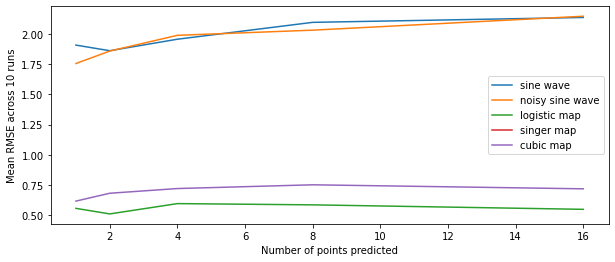

In [45]:
# plotting mean RSME against number of points

fig = plt.figure()
fig.set_figwidth(10)
plt.plot(sine_wave_df["Num Points"], sine_wave_df["Mean RMSE"],label="sine wave")
plt.plot(noisy_sine_wave_df["Num Points"], noisy_sine_wave_df["Mean RMSE"],label="noisy sine wave")
plt.plot(logistic_map_df["Num Points"], logistic_map_df["Mean RMSE"],label="logistic map")
# singer map currently having inf/nan loss so it doesn't appear on the graph
plt.plot(singer_map_df["Num Points"], singer_map_df["Mean RMSE"],label="singer map")
plt.plot(cubic_map_df["Num Points"], cubic_map_df["Mean RMSE"],label="cubic map")
plt.xlabel("Number of points predicted")
plt.ylabel("Mean RMSE across 10 runs")
plt.legend()
plt.show()

In [ ]:
# window size of 5
sine_wave_5_df = sine_wave_df

# window size of 10
sine_wave_10_df = pd.DataFrame(columns=["Num Points", "Mean RMSE"])
for num_points in N:
    rmse = []
    for i in range(runs):   
        print(f"Points to predict: {num_points}")
        print(f"Run number {i+1}")
        output = sine_wave_prediction(window_sizes[1], num_points)
        rmse.append(output[0]["test_loss"])
    # get mean RMSE across 10 runs for each num_points value
    mean_rmse = statistics.mean(rmse)
    sine_wave_10_df.loc[len(sine_wave_10_df.index)] = [int(num_points), mean_rmse]
    

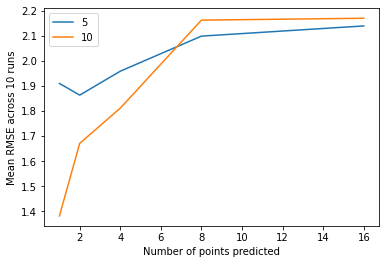

In [44]:
# plotting effect of window size on mean RMSE
# should add more window sizes here :)

plt.plot(sine_wave_5_df["Num Points"], sine_wave_5_df["Mean RMSE"],label="5")
plt.plot(sine_wave_10_df["Num Points"], sine_wave_10_df["Mean RMSE"],label="10")
plt.xlabel("Number of points predicted")
plt.ylabel("Mean RMSE across 10 runs")
plt.legend()
plt.show()